<a href="https://colab.research.google.com/github/zanderman/stock-forecasting-transformer/blob/main/Stock_predict_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
import joblib
import seaborn as sns

import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras import layers

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

import pywt
import math

import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


import scipy.io

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tue May  3 09:55:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Acquiring Dataset

In [4]:
!pip install kaggle

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [6]:
!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs

 99% 486M/492M [00:14<00:00, 49.4MB/s]
100% 492M/492M [00:14<00:00, 35.7MB/s]


In [ ]:
!unzip price-volume-data-for-all-us-stocks-etfs.zip

## Read Dataset

In [10]:
ticker = 'AAPL'
dataset = pd.read_csv(f"/content/Data/Stocks/{ticker.lower()}.us.txt", sep=",")

In [11]:
dataset.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [12]:
dataset.shape

(8364, 7)

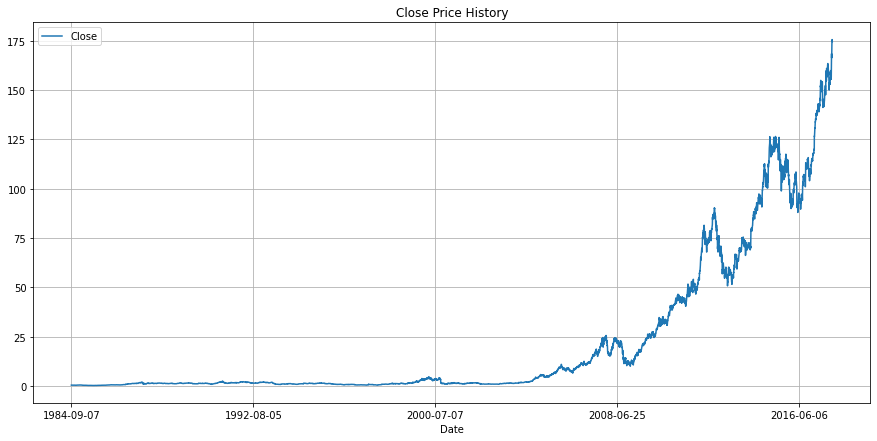

In [13]:
dataset.plot(x='Date', y='Close', figsize=(15,7), grid=True, title='Close Price History')

In [14]:
# Extract Features used in training and predictions
df_train = dataset.drop(['Date', 'Volume', 'OpenInt'], axis=1)
train = df_train.to_numpy()
print(f"training set shape: {train.shape}")
print(train)

# Exctract Dates
datelist_train = list(dataset['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
print(f"Number of all timestamps: {len(datelist_train)}")

training set shape: (8364, 4)
[[  0.42388   0.42902   0.41874   0.42388]
 [  0.42388   0.42516   0.41366   0.42134]
 [  0.42516   0.43668   0.42516   0.42902]
 ...
 [174.03    175.61    173.71    175.61   ]
 [174.48    175.46    172.52    175.25   ]
 [175.11    175.38    174.27    174.67   ]]
Number of all timestamps: 8364


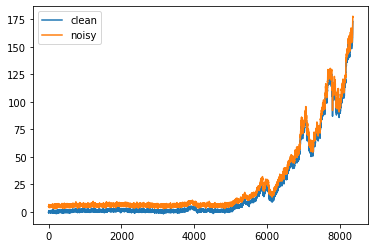

In [17]:
# Add noise (optional) run ony once
plt.plot(train[:,2:3], label='clean')

mean = 5
std = 0.5

train = train + np.random.normal(mean, std, train.shape)

plt.plot(train[:,2:3], label='noisy')
plt.legend()
plt.show()

In [18]:
# Feature scaling
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

sc_predict = MinMaxScaler(feature_range=(0,1))
sc_predict.fit_transform(train[:,0:1])


array([[0.01676759],
       [0.01028369],
       [0.01154323],
       ...,
       [0.98959442],
       [0.9919406 ],
       [1.        ]])

In [25]:
# Creating data structure
X_train = []
y_train = []

n_future = 30   # Number of days we want to predict into the future
n_past = 90     # Number of past days we want the model to learn from

for i in range(n_past, len(train_scaled)-n_future+1):
  X_train.append(train_scaled[i-n_past:i, 0:train.shape[1]-1])
  y_train.append(train_scaled[i+n_future-1:i+n_future,0])

X_train, y_train = np.array(X_train, dtype="float64"), np.array(y_train, dtype="float64")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (8245, 90, 3)
y_train shape: (8245, 1)


## Creating the Model

In [26]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(n_past, train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=64, return_sequences=False))

# Adding Dense layer
model.add(Dense(units=25))

# Adding Dropout layer
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 90, 128)           67584     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 25)                1625      
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 118,643
Trainable params: 118,643
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [27]:
# Callbacks
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

history = model.fit(X_train, y_train, shuffle=True, epochs=50, validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/50
26/26 [==============================] - 4s 48ms/step - loss: 5.0271e-04 - val_loss: 0.0022
Epoch 2/50
26/26 [==============================] - 0s 17ms/step - loss: 1.7560e-04 - val_loss: 0.0023
Epoch 3/50
26/26 [==============================] - 0s 17ms/step - loss: 1.5464e-04 - val_loss: 0.0025
Epoch 4/50
26/26 [==============================] - 0s 17ms/step - loss: 1.4986e-04 - val_loss: 0.0032
Epoch 5/50
26/26 [==============================] - 0s 17ms/step - loss: 1.5222e-04 - val_loss: 0.0032
Epoch 6/50
26/26 [==============================] - 0s 17ms/step - loss: 1.3957e-04 - val_loss: 0.0024
Epoch 7/50
26/26 [==============================] - 0s 17ms/step - loss: 1.4400e-04 - val_loss: 0.0023
Epoch 8/50
26/26 [==============================] - 0s 16ms/step - loss: 1.4550e-04 - val_loss: 0.0026
Epoch 9/50
26/26 [==============================] - 0s 18ms/step - loss: 1.3040e-04 - val_loss: 0.0040
Epoch 10/50
26/26 [==============================] - 0s 17ms/step - loss:

## Making Predictions

In [29]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

In [30]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [31]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
1985-07-08,5.221628
1985-07-09,5.386560
1985-07-10,5.456230


In [32]:
# Parse training set timestamp for better visualization
df_train.index = datelist_train
df_train.index = pd.to_datetime(df_train.index)

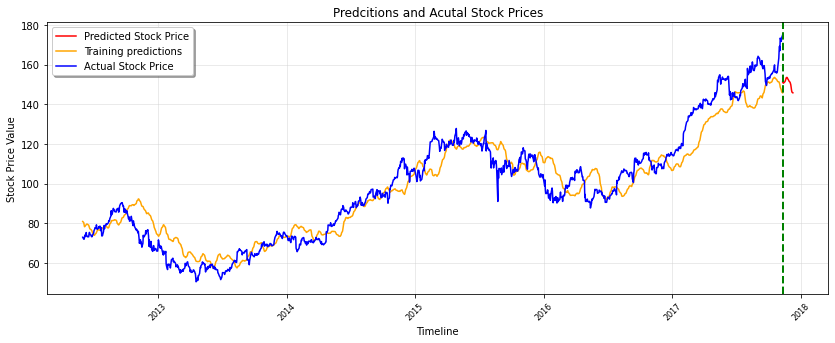

In [33]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df_train.loc[START_DATE_FOR_PLOTTING:].index, df_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Stock Price Value', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [ ]:
PREDICTIONS_FUTURE.shape

(1, 1)